In [1]:
# HÜCRE 1: Başlangıç Ayarları
from google.colab import drive
import os
import librosa
import numpy as np
import pandas as pd

# 1. Drive Bağlantısı
drive.mount('/content/drive')

# 2. Dosya Yolu
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/SER_Projesi/audio_speech_actors_01-24'

wav_files = []
for root, dirs, files in os.walk(DATA_PATH):
    for file in files:
        if file.endswith(".wav"):
            wav_files.append(os.path.join(root, file))

print(f" Ham Veri Yolu: {DATA_PATH}")
print(f" Bulunan Dosya: {len(wav_files)}")

Mounted at /content/drive
 Ham Veri Yolu: /content/drive/MyDrive/Colab Notebooks/SER_Projesi/audio_speech_actors_01-24
 Bulunan Dosya: 1440


In [2]:
# HÜCRE 2: 10 Kat Veri Çoğaltma Fonksiyonları

DURATION = 3
SAMPLE_RATE = 22050
TOTAL_SAMPLES = DURATION * SAMPLE_RATE

# --- YARDIMCI FONKSİYONLAR ---
def augment_noise(data):
    noise_amp = 0.04 * np.random.uniform() * np.amax(data)
    return data + noise_amp * np.random.normal(size=data.shape[0])

def augment_shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(data, shift_range)

def augment_stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data, rate=rate)

def augment_pitch(data, sr, steps=2):
    return librosa.effects.pitch_shift(y=data, sr=sr, n_steps=steps)

def extract_features(data, sample_rate):
    # Boyut Sabitleme
    if len(data) > TOTAL_SAMPLES:
        data = data[:TOTAL_SAMPLES]
    else:
        padding = TOTAL_SAMPLES - len(data)
        data = np.pad(data, (0, padding), 'constant')

    mfcc = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40)
    return np.mean(mfcc.T, axis=0)

def process_audio_extreme(path):
    data, sr = librosa.load(path, duration=DURATION, offset=0.5, res_type='kaiser_fast')

    # Ana boyuta sabitleme
    if len(data) > TOTAL_SAMPLES: data = data[:TOTAL_SAMPLES]
    else: data = np.pad(data, (0, TOTAL_SAMPLES - len(data)), 'constant')

    results = []

    # 1. Orijinal
    results.append(extract_features(data, sr))

    # 2. Noise
    results.append(extract_features(augment_noise(data), sr))

    # 3. Stretch (Yavaş - 0.9)
    results.append(extract_features(augment_stretch(data, rate=0.9), sr))

    # 4. Stretch (Hızlı - 1.1)
    results.append(extract_features(augment_stretch(data, rate=1.1), sr))

    # 5. Shift
    results.append(extract_features(augment_shift(data), sr))

    # 6. Pitch Up (İnce ses)
    results.append(extract_features(augment_pitch(data, sr, steps=2), sr))

    # 7. Pitch Down (Kalın ses)
    results.append(extract_features(augment_pitch(data, sr, steps=-2), sr))

    # 8. Combo: Noise + Shift
    results.append(extract_features(augment_shift(augment_noise(data)), sr))

    # 9. Combo: Pitch + Stretch
    temp = augment_pitch(data, sr, steps=1.5)
    results.append(extract_features(augment_stretch(temp, rate=0.9), sr))

    # 10. Combo: Pitch + Noise
    results.append(extract_features(augment_noise(augment_pitch(data, sr, steps=-1.5)), sr))

    return results

print(" Augmentation Hazır!")

 Augmentation Hazır!


In [3]:
!pip install resampy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 84.4 MB/s eta 0:00:00


In [4]:
# HÜCRE 3 : Smart Balancing ile İşleme ve Kaydetme

X = []
y = []

# Duygu haritası
emotion_map = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
}

print("Akıllı Veri Üretimi Başladı.")

counter = 0

for file in wav_files:
    file_name = os.path.basename(file)
    emotion_code = file_name.split("-")[2]
    emotion_label = emotion_map.get(emotion_code)

    # Eğer duygu 'neutral' ise döngü 2 kere dönsün ,

    repeat_count = 2 if emotion_label == 'neutral' else 1

    for i in range(repeat_count):
        # process_audio_extreme fonksiyonu içinde rastgelelik olduğu için ikinci kez çağırdığımızda tamamen farklı 10 varyasyon daha üretecek.
        features = process_audio_extreme(file)

        for feat in features:
            X.append(feat)
            y.append(emotion_label)

    counter += 1
    if counter % 50 == 0:
        print(f"İşlenen Dosya: {counter} | Şu anki Veri Stoğu: {len(X)}")

print("------------------------------------------------")
print(f"İŞLEM BİTTİ! Toplam Veri Sayısı: {len(X)}")

# --- KAYDETME AŞAMASI ---
print("Veriler Drive'a kaydediliyor...")

X_np = np.array(X)
y_np = np.array(y)

SAVE_PATH = '/content/drive/MyDrive/Colab Notebooks/SER_Projesi/'

# Klasör yoksa oluştur (Garanti olsun)
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)

np.save(SAVE_PATH + 'X_features_10x.npy', X_np)
np.save(SAVE_PATH + 'y_labels_10x.npy', y_np)

print(f"KAYDEDİLDİ! Dosyalar şurada: {SAVE_PATH}")
print("Artık veri setimiz Dengeli!")

Akıllı Veri Üretimi Başladı.
İşlenen Dosya: 50 | Şu anki Veri Stoğu: 540
İşlenen Dosya: 100 | Şu anki Veri Stoğu: 1080
İşlenen Dosya: 150 | Şu anki Veri Stoğu: 1620
İşlenen Dosya: 200 | Şu anki Veri Stoğu: 2160
İşlenen Dosya: 250 | Şu anki Veri Stoğu: 2680
İşlenen Dosya: 300 | Şu anki Veri Stoğu: 3200
İşlenen Dosya: 350 | Şu anki Veri Stoğu: 3740
İşlenen Dosya: 400 | Şu anki Veri Stoğu: 4280
İşlenen Dosya: 450 | Şu anki Veri Stoğu: 4820
İşlenen Dosya: 500 | Şu anki Veri Stoğu: 5360
İşlenen Dosya: 550 | Şu anki Veri Stoğu: 5880
İşlenen Dosya: 600 | Şu anki Veri Stoğu: 6400
İşlenen Dosya: 650 | Şu anki Veri Stoğu: 6940
İşlenen Dosya: 700 | Şu anki Veri Stoğu: 7470
İşlenen Dosya: 750 | Şu anki Veri Stoğu: 8020
İşlenen Dosya: 800 | Şu anki Veri Stoğu: 8560
İşlenen Dosya: 850 | Şu anki Veri Stoğu: 9060
İşlenen Dosya: 900 | Şu anki Veri Stoğu: 9600
İşlenen Dosya: 950 | Şu anki Veri Stoğu: 10140
İşlenen Dosya: 1000 | Şu anki Veri Stoğu: 10680
İşlenen Dosya: 1050 | Şu anki Veri Stoğu: 11210
İş

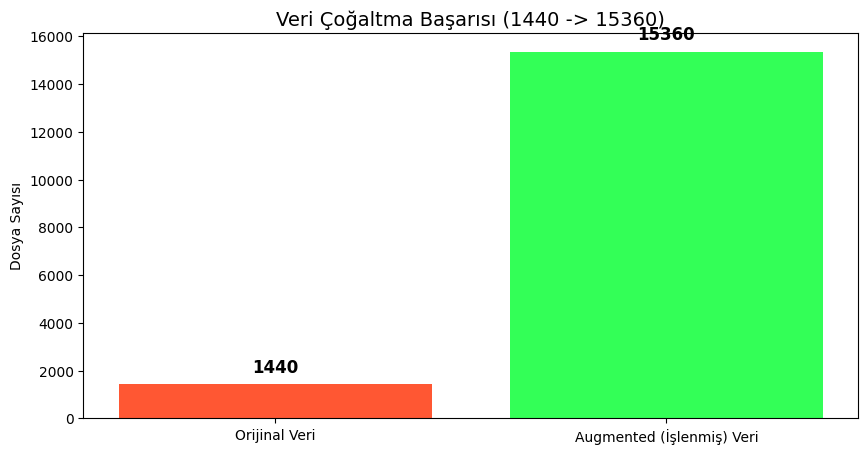

/tmp/ipython-input-3223874061.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Emotions', data=df_new, order=order_list, palette='viridis')


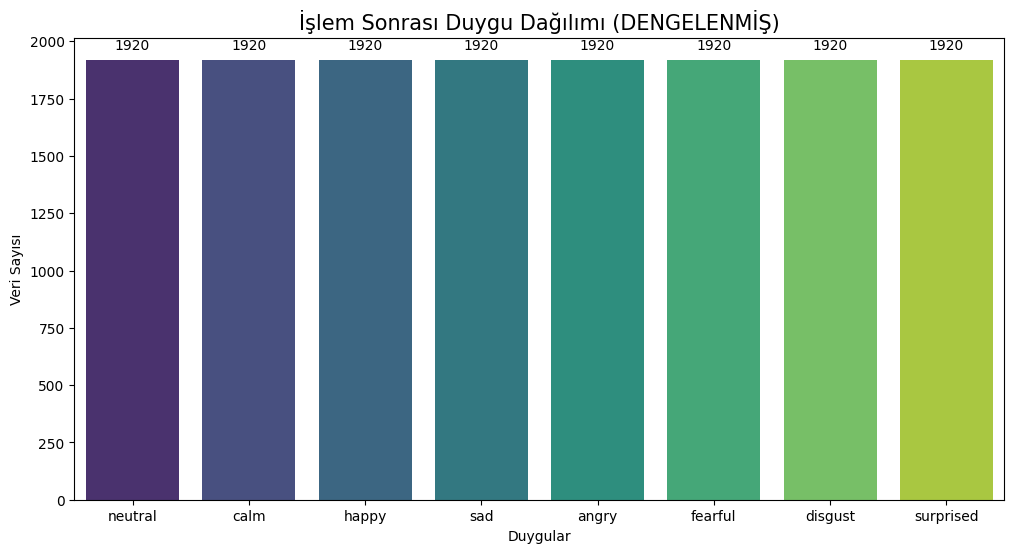

Rapor:
1. Toplam Veri: 1440'den 15360'e çıktı.
2. Dengesiz olan 'Neutral' sınıfı, Smart Balancing ile diğerlerine eşitlendi.
3. Bu veri seti artık Deep Learning modeli için MÜKEMMEL durumda.


In [5]:
# HÜCRE 4: İşlem Sonrası Görsel Analiz (Before vs After)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Veri Hazırlığı
# Orijinal sayı
original_count = len(wav_files)
# Yeni sayı
augmented_count = len(X)

# 2. Grafik: Veri Hacmi Artışı
plt.figure(figsize=(10, 5))
bars = plt.bar(['Orijinal Veri', 'Augmented (İşlenmiş) Veri'],
               [original_count, augmented_count],
               color=['#FF5733', '#33FF57'])

plt.title(f'Veri Çoğaltma Başarısı ({original_count} -> {augmented_count})', fontsize=14)
plt.ylabel('Dosya Sayısı')

# Çubukların üzerine sayıları yazalım
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 500, int(yval), ha='center', fontsize=12, fontweight='bold')

plt.show()

# 3. Grafik: Yeni Sınıf Dağılımı

plt.figure(figsize=(12, 6))
df_new = pd.DataFrame(y, columns=['Emotions'])

# Sıralama sabitlendi
order_list = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

ax = sns.countplot(x='Emotions', data=df_new, order=order_list, palette='viridis')

plt.title('İşlem Sonrası Duygu Dağılımı (DENGELENMİŞ)', fontsize=15)
plt.xlabel('Duygular')
plt.ylabel('Veri Sayısı')

# Sayıları sütunların üzerine yaz
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', fontsize=10)

plt.show()

print("Rapor:")
print(f"1. Toplam Veri: {original_count}'den {augmented_count}'e çıktı.")
print("2. Dengesiz olan 'Neutral' sınıfı, Smart Balancing ile diğerlerine eşitlendi.")
print("3. Bu veri seti artık Deep Learning modeli için MÜKEMMEL durumda.")